<h1>Deep Learning in Computer Vision: An Image Classifier with Transfer Learning (Project)</h1>


An Efficient Image classifier with Transfer Leaning based on the **Convolutional Neural Network (ConvNet)**.

***
## Table of Contents

[1. Import Libraries](#1.-Import-Libraries) <br>
[2. Image Processing and Load Data](#2.-Image-Processing-and-Load-Data)<br>
[3. Data Preparation](#3.-Data-Preparation)
   - [3.1. Image Transformations](#3.1.-Image-Transformations)
   - [3.2. Load Datasets with Transformations](#3.2.-Load-Datasets-with-Transformations)

[4. Hyperparameters](#4.-Hyperparameters)
   - [4.1. Epochs and Batch Size](#4.1.-Epochs-and-Batch-Size)
   - [4.2. Learning Rate and Momentum](#4.2.-Learning-Rate-and-Momentum)
   - [4.3. Learning Rate Scheduler](#4.3.-Learning-Rate-Scheduler)

[5. Model Loading](#5.-Model-Loading)<br>
[6. Model Training](#6.-Model-Training)<br>
[7. Model Evaluation](#7.-Model-Evaluation)<br>
[8. Model Testing](#8.-Model-Testing)
***

## 1. Import Libraries


In [72]:
# OS and Cloud
import os, uuid, shutil, json, copy, zipfile, io, requests, random
from datetime import datetime

# Data Processing and Visualization
import math, time
import copy, logging
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np, pandas as pd, utils_data.cvision_plot as cvplot
from tqdm import tqdm
from tqdm.auto import tqdm
from typing import List, Dict, Optional, Union, Tuple
from ipywidgets import IntProgress

# Deep Learning
import torch, torch.utils.data
import torchvision.models as models, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

torch.manual_seed(0);

In [ ]:
# Define device as the first visible cuda device:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The device type is', device)

## 2. Image Processing and Load Data


In [ ]:
zip_file_path = 'data/project-stop-signs.zip'

# Define the target directory where you want to extract the files
extraction_directory = 'project-stop-signs/'

# Check if the local zip file exists
if os.path.exists(zip_file_path):
    try:
        # Open the zip file from the local path in read-binary mode
        with open(zip_file_path, 'rb') as f:
            with zipfile.ZipFile(f) as zip_ref:
                # Create the target directory if it doesn't exist
                os.makedirs(extraction_directory, exist_ok=True)
                zip_ref.extractall(extraction_directory)  # Extract to the target folder
        print(f"Extraction complete. Files saved to: {os.path.abspath(extraction_directory)}")

    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file or is corrupted.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print(f"Error: The file '{zip_file_path}' does not exist.")

In [5]:
# Path
source_dir = 'data/project-stop-signs' 
annotations_file = os.path.join(source_dir, '_annotations.json') 

# Load annotations
with open(annotations_file, 'r') as f:
    annotations = json.load(f)

# Parameters
train_ratio = 0.9
output_dir = 'dataset' 

# Prepare Label to Image Mapping
label_to_images = {}

for filename, entry in annotations['annotations'].items():
    label = entry[0]['label']
    label_to_images.setdefault(label, []).append(filename)

In [48]:
# Train and Validation Datasets

for label, image_list in label_to_images.items():
    random.shuffle(image_list)  
    
    train_cutoff = int(len(image_list) * train_ratio)
    
    train_images = image_list[:train_cutoff]
    val_images = image_list[train_cutoff:]

    for split, split_images in zip(['train', 'val'], [train_images, val_images]):
        
        out_path = os.path.join(output_dir, split, label)
        os.makedirs(out_path, exist_ok=True) 

        for img_name in split_images:
            src = os.path.join(source_dir, img_name)  
            dst = os.path.join(out_path, img_name)  
            shutil.copy2(src, dst) 

print('Train / Validation Split completed.')


Train / Validation Split completed.


## 3. Data Preparation

### 3.1. Image Transformations

In [49]:
# Define a series of transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225] 
    )
])

### 3.2. Load Datasets with Transformations

In [50]:
# Load datasets from the respective folders
train_dataset = ImageFolder(root='dataset/train', transform=transform)
val_dataset = ImageFolder(root='dataset/val', transform=transform)

## 4. Hyperparameters


### 4.1. Epochs and Batch Size

In [51]:
# Number of epochs and batch size
n_epochs = 10 
batch_size = 32 

### 4.2. Learning Rate and Momentum

In [52]:
# Optimizer hyperparameters
learning_rate = 0.000001 
momentum = 0.9 

### 4.3. Learning Rate Scheduler

In [53]:
# Enable learning rate scheduling
lr_scheduler = True    
base_lr = 0.001            
max_lr = 0.01              

## 5. Model Loading


### 5.1. Load a Pretrained Model


In [54]:
# Load the model using the recommended weights enum
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

### 5.2. Freeze Feature Extractor Layers


In [55]:
# Freeze all the parameters to prevent updates during training
for param in model.parameters():
    param.requires_grad = False

### 5.3. Determine the Number of Classes

In [56]:
# Find number of classes from the dataset
n_classes = len(train_dataset.classes)
print(f'The number of classes from the dataset is {n_classes:.0f}')

The number of classes from the dataset is 4


### 5.4. Replace the Output Layer

In [57]:
# Find the number of input features for the existing final layer
num_ftrs = model.fc.in_features

# Replace the output layer (fc stands for fully connected layer) to match the number of classes
model.fc = nn.Linear(num_ftrs, n_classes)

In [58]:
# Set device type
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 5.5. Define the Loss Function


In [59]:
# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

### 5.6. Create Data Loaders

In [60]:
# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1)

### 5.7. Set Up the Optimizer
Instruction: Use the SGD optimizer to update the model parameters during training.

In [61]:
# Initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

### 5.8. Configure a Learning Rate Scheduler

In [62]:
# Learning rate scheduler
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=base_lr,   
        max_lr=max_lr,         
        step_size_up=5,
        mode='triangular2'
    )

### 5.9. Implement and Analyze the Training Loop

In [63]:
# Training loop
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)

# Define the training function with type hints and explicit parameter passing
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    n_epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    print_output: bool = True
) -> Tuple[List[float], List[float], nn.Module]:
    """
    Trains a PyTorch model, validates it, and returns the best performing model based on accuracy.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        validation_loader: DataLoader for the validation data.
        criterion: The loss function.
        optimizer: The optimizer.
        n_epochs: The number of epochs to train for.
        device: The device (CPU or GPU) to run the training on.
        scheduler: An optional learning rate scheduler.
        print_output: If True, prints detailed output during training.

    Returns:
        A tuple containing:
        - List of validation accuracies per epoch.
        - List of average training losses per epoch.
        - The best performing model (with weights loaded from the best epoch).
    """
    loss_list: List[float] = []        # Store average training loss per epoch
    accuracy_list: List[float] = []    # Store validation accuracy per epoch

    # Calculate total number of validation samples once
    n_test = len(validation_loader.dataset)
    accuracy_best = 0.0
    # Use deepcopy for the model state dictionary
    best_model_wts = copy.deepcopy(model.state_dict())

    if print_output:
        logger.info('Starting training. The first epoch may take a few minutes.')

    for epoch in tqdm(range(n_epochs), desc='Training Epochs'):
        model.train()  # Set model to training mode
        loss_sublist: List[float] = []
        correct_train = 0
        total_train = 0

        for x, y in train_loader:
            # Move data to the specified device
            x, y = x.to(device), y.to(device)

            # Zero the parameter gradients before backpropagation
            optimizer.zero_grad()

            # Forward pass
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track training accuracy (optional, can be removed to speed up)
            _, predicted = torch.max(z.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()

        avg_train_loss = np.mean(loss_sublist)
        loss_list.append(avg_train_loss)

        # Step learning rate scheduler (if provided)
        if scheduler:
            scheduler.step()

        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_val = 0
        with torch.no_grad():  # Disable gradient calculation during validation
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct_val += (yhat == y_test).sum().item()

        accuracy = correct_val / n_test
        accuracy_list.append(accuracy)

        # Check if this is the best model so far
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            if print_output:
                logger.info(f'New best model found at epoch {epoch + 1} with accuracy: {accuracy:.4f}')

        if print_output:
            logger.info('-' * 30)
            logger.info(f'Epoch {epoch + 1}/{n_epochs} summary:')
            logger.info(f'Learning Rate: {optimizer.param_groups[0]['lr']:.6f}')
            logger.info(f'Training Loss: {avg_train_loss:.4f}')
            logger.info(f'Validation Accuracy: {accuracy:.4f}')
            logger.info('-' * 30)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    logger.info(f'Training complete. Best validation accuracy achieved: {accuracy_best:.4f}')

    return accuracy_list, loss_list, model

## 6. Model Training

In [ ]:
# Start time tracking
start_datetime = datetime.now()
start_time = time.time()

# Train the model
accuracy_list, loss_list, model = train_model(
    model, train_loader, validation_loader, criterion, optimizer, n_epochs=n_epochs, device=device
)

# End time tracking
end_datetime = datetime.now()
elapsed_time = time.time() - start_time

# Print results
print('Training completed.')
print(f'Start Time     : {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}')
print(f'End Time       : {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}')
print(f'Elapsed Time   : {elapsed_time:.2f} seconds')


In [68]:
# Save the model to model.pt
torch.save(model.state_dict(), 'data/project-stop-signs/model.pt')

## 7. Model Evaluation

### 7.1. Training Loss and Validation Accuracy Plot

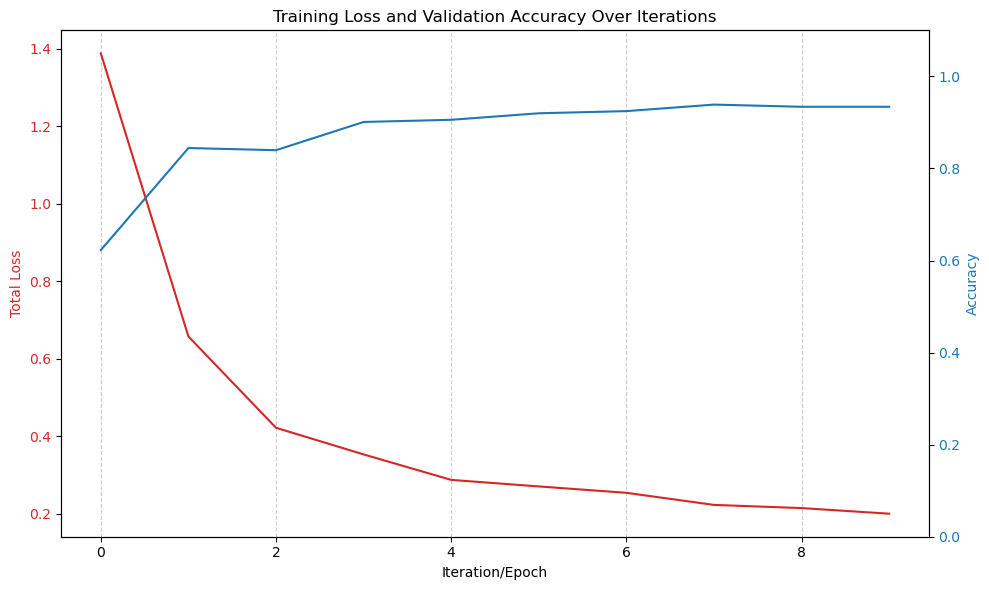

In [69]:
# Learning curves plot
cvplot.plot_metrics(loss_list, accuracy_list)

## 8. Model Testing


### 8.1. Trained Model for Inference


In [ ]:
# Define class labels used during training
class_names = ['not_stop', 'stop']

# Load the same pretrained architecture used during training
model = models.resnet18(pretrained=False)

# Replace the fully connected layer to match number of output classes
n_classes = len(class_names)
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)

# Load trained model weights
model.load_state_dict(torch.load('data/project-stop-signs/model.pt', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()  

### 8.2. Image Preprocessing for Prediction

In [60]:
# Define the same image transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),     
    transforms.ToTensor(),              
    transforms.Normalize([0.485, 0.456, 0.406],  
                         [0.229, 0.224, 0.225])
])

### 8.3. Image Loading and Convertion


In [61]:
# Image loading
image_path = 'data/project-stop-signs/stop_1.jpeg'
image = Image.open(image_path).convert('RGB')  

# Apply transformations and add batch dimension 
input_tensor = transform(image).unsqueeze(0)

### 8.3. Model Prediction



The image was classified as: stop


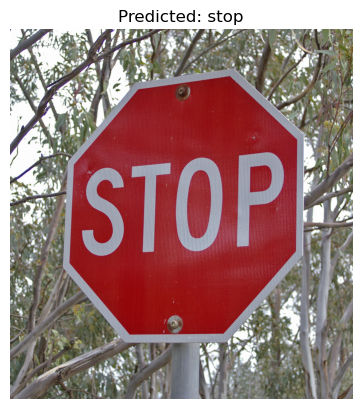

In [62]:
# Inference without tracking gradients
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, dim=1)
    predicted_class = predicted.item() 

print(f'The image was classified as: {class_names[predicted_class]}')

# Image visualization with the predicted label
plt.imshow(image)
plt.title(f'Predicted: {class_names[predicted_class]}')
plt.axis('off')
plt.show()

***
Author: Dr. Olga Khon, PhD in Finance